In [2]:
import geopandas
import pandas
import pathlib
import numpy
import matplotlib
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
sampling_resolution = 10
threshold = 1

## Load in results
### Widths and slopes

In [4]:
width_file = pathlib.Path(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\caches\100000000_full_bank\final_transect_values.geojson")
rec_main_channel_file = pathlib.Path(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\caches\100000000_full_bank\rec_main_channel.geojson")
widths = geopandas.read_file(width_file)
main_channel = geopandas.read_file(rec_main_channel_file)

### Slopes and Flows

In [5]:
mannings_file = pathlib.Path(r"C:\Users\pearsonra\Documents\data\river_bathemetry\mannings_n\bathy.csv.gz")
mannings = pandas.read_csv(mannings_file)

### Measured cross sections

In [6]:
cross_section_file = pathlib.Path(r"C:/Users/pearsonra/Documents/data/river_bathemetry/sections/Waikanae/Waikanae_Cross_Sections_NIWA/2014_Survey_XS_NZTM.shp")
cross_sections = geopandas.read_file(cross_section_file)

### Local datum conversion

In [7]:
local_datum_file = pathlib.Path(r"C:\Users\pearsonra\Documents\data\local_datums\lds-wellington-1953-to-nzvd2016-conversion-raster-GTiff\wellington-1953-to-nzvd2016-conversion-raster.tif")

In [8]:
import rioxarray
with rioxarray.rioxarray.open_rasterio(local_datum_file, masked=True) as local_vertical_datum:
            local_vertical_datum.load()

# Translate the samples to correct reach

In [9]:
widths['nzsegment'] = numpy.zeros(len(widths['widths']), dtype=int) * -1
for i, row in main_channel.iterrows():
    widths.loc[widths.intersects(row.geometry), ('nzsegment')] = row['nzsegment']

#### Temporary - manaully set last value

In [10]:
widths.loc[1045, ('nzsegment')]=widths['nzsegment'].iloc[1044]

# Add the flows and manning's n to the widths table

In [11]:
slope_name = 'slope_mean_0.5km'
min_z_name = 'min_z_centre_unimodal_mean_0.5km'
width_name = 'widths_mean_0.25km'

In [12]:
key_parameters = widths[['nzsegment', slope_name, width_name, 'geometry', min_z_name, 'min_z_centre_unimodal']]
key_parameters = key_parameters[key_parameters['nzsegment'] != 0]

In [13]:
key_parameters['mannings_n'] = numpy.zeros(len(key_parameters['nzsegment']), dtype=int)
key_parameters['flow'] = numpy.zeros(len(key_parameters['nzsegment']), dtype=int)
for nzsegment in key_parameters['nzsegment'].unique():
    key_parameters.loc[key_parameters['nzsegment'] == nzsegment, ('mannings_n')] = mannings[mannings['nzsegment'] == nzsegment]['n'].unique()[0]
    key_parameters.loc[key_parameters['nzsegment'] == nzsegment, ('flow')] = mannings[mannings['nzsegment'] == nzsegment]['flow'].unique()[0]

Note a section is out of order, which is why the flow goes down.

<AxesSubplot:>

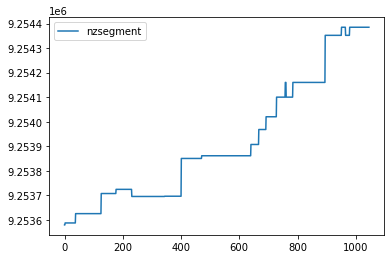

In [14]:
key_parameters[['nzsegment']].plot()

## Calculate depth

In [15]:
key_parameters['depth_Neal_et_al'] = (key_parameters['mannings_n'] * key_parameters['flow'] \
                                      / (numpy.sqrt(key_parameters[slope_name]) \
                                         * key_parameters[width_name])) ** (3/5) - threshold

In [16]:
a = 0.745
b = 0.305
K_0 = 6.16

In [17]:
key_parameters['depth_Smart_et_al'] = \
    (key_parameters['flow'] / (K_0 * key_parameters[width_name] * key_parameters[slope_name] ** b)) ** (1 / (1+a)) - threshold

## Plot results
Include plots of each parameter - Manning's n, flow, depth and slope - used to calculate depth

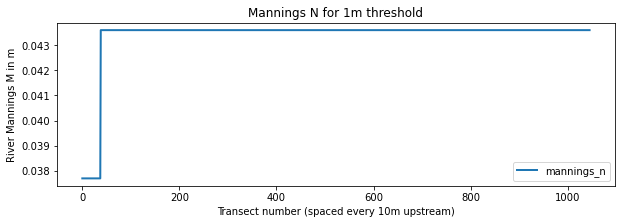

In [18]:
f, ax = matplotlib.pyplot.subplots(figsize=(10, 3))
key_parameters[['mannings_n']].plot(ax=ax, linewidth=2)
ax.set(title=f"Mannings N for {threshold}m threshold")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River Mannings M in m");

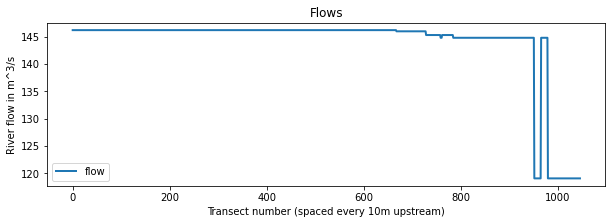

In [19]:
f, ax = matplotlib.pyplot.subplots(figsize=(10, 3))
key_parameters[['flow']].plot(ax=ax, linewidth=2)
ax.set(title=f"Flows")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River flow in m^3/s");

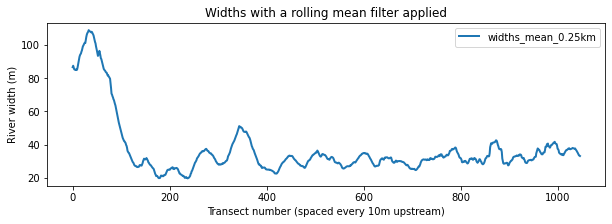

In [20]:
f, ax = matplotlib.pyplot.subplots(figsize=(10, 3))
key_parameters[[width_name]].plot(ax=ax, linewidth=2)
ax.set(title=f"Widths with a rolling mean filter applied")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River width (m)");

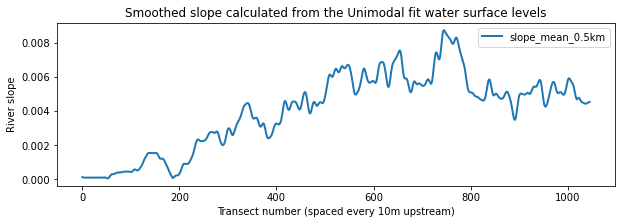

In [21]:
f, ax = matplotlib.pyplot.subplots(figsize=(10, 3))
key_parameters[[slope_name]].plot(ax=ax, linewidth=2)
ax.set(title=f"Smoothed slope calculated from the Unimodal fit water surface levels")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River slope");

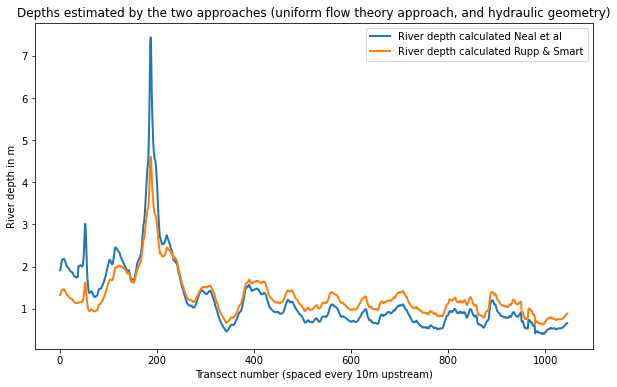

In [22]:
f, ax = matplotlib.pyplot.subplots(figsize=(10, 6))
key_parameters['depth_Neal_et_al'].plot(ax=ax, linewidth=2, label='River depth calculated Neal et al')
key_parameters['depth_Smart_et_al'].plot(ax=ax, linewidth=2, label='River depth calculated Rupp & Smart')
ax.set(title="Depths estimated by the two approaches (uniform flow theory approach, and hydraulic geometry)")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River depth in m");
matplotlib.pyplot.legend()

## Measured cross sections

Plot minimum height (i.e height of the bed)

Add the LVD conversion

In [23]:
def get_lvd_conversion(geometry, local_vertical_datum):
    return local_vertical_datum.sel({'x': [geometry.x], 'y': [geometry.y]}, method='nearest').data[0,0,0]

cross_sections['lvd_conversion'] = cross_sections.apply(lambda row: get_lvd_conversion(row.geometry, local_vertical_datum), axis=1)
cross_sections['z_2016'] = cross_sections['Level'] - cross_sections['lvd_conversion']

Pull out the centre point for each section - for idntification of the nearest sampled transect

In [24]:
section_centres = {'Section': [], 'geometry': []}
for section in cross_sections['Section'].unique():
    section_centre = cross_sections[cross_sections['Section'] == section].iloc[round(len(cross_sections[cross_sections['Section'] == section])/2)]
    section_centres['Section'].append(section_centre['Section'])
    section_centres['geometry'].append(section_centre['geometry'])
section_centres = geopandas.GeoDataFrame(section_centres, crs=main_channel.crs)

Cycle through each section identifying the nearest section in the key parameters

In [25]:
nearest_transect = numpy.zeros_like(key_parameters[slope_name], dtype=bool)
for index, row in section_centres.iterrows():
    nearest_transect[key_parameters.distance(row.geometry).argmin()] = True

nearest_key_parameters = key_parameters[nearest_transect]

## Plot the depths of the two approaches

### Compare the depth results to measured

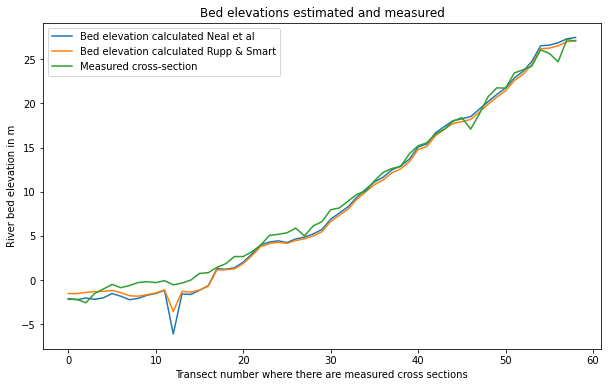

In [26]:
f, ax = matplotlib.pyplot.subplots(figsize=(10, 6))
(nearest_key_parameters[min_z_name]-nearest_key_parameters['depth_Neal_et_al']).reset_index(drop=True).plot(label='Bed elevation calculated Neal et al')
(nearest_key_parameters[min_z_name]-nearest_key_parameters['depth_Smart_et_al']).reset_index(drop=True).plot(label='Bed elevation calculated Rupp & Smart')
cross_sections.groupby('Section')['z_2016'].min().reset_index(drop=True).plot(label='Measured cross-section')
ax.set(title="Bed elevations estimated and measured")
matplotlib.pyplot.xlabel(f"Transect number where there are measured cross sections")
matplotlib.pyplot.ylabel(f"River bed elevation in m");
matplotlib.pyplot.legend()

Plot the nearest widths

### Plot other values
* Widths - nearest the measured cross sections
* Measured cross section depth compared to water surface height

In [ ]:
f, ax = matplotlib.pyplot.subplots(figsize=(20, 6))
nearest_key_parameters[[width_name]].reset_index(drop=True).plot(ax=ax)
ax.set(title="Estimated width nearest to measured cross section")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"Channel width (m)");
matplotlib.pyplot.legend()

In [ ]:
f, ax = matplotlib.pyplot.subplots(figsize=(20, 6))
nearest_key_parameters[['min_z_centre_unimodal', 'min_z_centre']].reset_index(drop=True).plot(ax=ax)
cross_sections.groupby('Section')['z_2016'].min().reset_index(drop=True).plot(ax=ax, label='Measured cross-section depth')
ax.set(title="Measured depth compared to estimated water surface elevation")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"Elevation (m)");
matplotlib.pyplot.legend()

### Plots exploring the change to width to produce an expected bed elevation

In [ ]:
fudge_factor = 2
depth_wider = (nearest_key_parameters['mannings_n'] * nearest_key_parameters['flow'] / (numpy.sqrt(nearest_key_parameters['slope']) * nearest_key_parameters['widths_Savgol'] * fudge_factor)) ** (3/5) - threshold

f, ax = matplotlib.pyplot.subplots(figsize=(20, 6))
(nearest_key_parameters['min_z_centre_unimodal']-depth_wider).reset_index(drop=True).plot(label='Calculated from unimodal min_z')
(nearest_key_parameters['min_z_centre_unimodal_0.5km_rolling_mean'] - depth_wider).reset_index(drop=True).plot(label='Calculated from smooth unimodal min_z')
(nearest_key_parameters['min_z_centre']-depth_wider).reset_index(drop=True).plot(label='Calculated from min_z')
cross_sections.groupby('Section')['z_2016'].min().reset_index(drop=True).plot(label='Measured cross-section')
ax.set(title=f"Depths estimated using the Uniform Flow Throery approach with width mutiplier of {fudge_factor}")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River depth in m");
matplotlib.pyplot.legend()

In [ ]:
fudge_factor = 2
depth_wider = (nearest_key_parameters['flow'] / (K_0 * nearest_key_parameters['widths_Savgol'] * fudge_factor * nearest_key_parameters['slope'] ** b)) ** (1 / (1+a)) - threshold

f, ax = matplotlib.pyplot.subplots(figsize=(20, 6))
(nearest_key_parameters['min_z_centre_unimodal']-depth_wider).reset_index(drop=True).plot(label='Calculated from unimodal min_z')
(nearest_key_parameters['min_z_centre_unimodal_0.5km_rolling_mean']-depth_wider).reset_index(drop=True).plot(label='Calculated from smooth unimodal min_z')
(nearest_key_parameters['min_z_centre']-depth_wider).reset_index(drop=True).plot(label='Calculated from min_z')
cross_sections.groupby('Section')['z_2016'].min().reset_index(drop=True).plot(label='Measured cross-section')
ax.set(title=f"Depths estimated using the conceptual multivariate regression approach with width mutiplier of {fudge_factor}")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River depth in m");
matplotlib.pyplot.legend()

### Mics plots for reference: 
Water levels for 10m spaced transects

In [ ]:
f, ax = matplotlib.pyplot.subplots(figsize=(10, 3))
key_parameters[['min_z_centre_unimodal', 'min_z_centre_unimodal_0.5km_rolling_mean', 'min_z_centre']].plot(ax=ax, linewidth=2)
ax.set(title=f"Water surface as calculated from sampled transects")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"Water surface elevation");

Widths at 10m spacing

In [ ]:
f, ax = matplotlib.pyplot.subplots(figsize=(10, 3))
key_parameters[['widths_Savgol']].plot(ax=ax, linewidth=2)
ax.set(title="Channel width (m)")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"Estimated channel width");